# The Cointegrator Algorithm
## Introduction to Statistical Arbitrage
There is a consensus among many professionals in the world of quantitative finance that equity price movements are random. In statistical terms, this is saying that stock prices are "random walks," essentially meaning that each price is a random step away from the price at the previous time value (though it also requires first order integration). It It follows that many traders apply models of stochastic chaos such as that of Brownian motion, which is actually made to model the chaotic movement of gas molecules, and other kinetic models as well as equations from quantum mechanics. While this is very mathematically intriguing, such strategies are not the subjects of this post.

Another approach to modeling the random involves the identification of irregularities in price as opposed to forecasting regularities. While we may not be able to predict the exact price movement of an equity, we may be able to identify anomalies in the price movement and anticipate some kind of a reversion from its current position to a historical mean, trend, etc.. The capitilization on such short-term trade opportunities is called arbitrage.

## The Pairs Trade & Cointegration
The pairs trade is one of the oldest techniques of statistical arbitrage, and probably originated in the 1990's at Morgan Stanley. It involves attaining opposite positions in two paired, or "cointegrated" equities.

The classic metaphor to explain the pairs trade is as follows: The movement of a blind drunkard walking his dog is random. Each of their two locations at any given time is considered to be a random step away from the previous location. However, we *do* know that if the dog's leash becomes fully displaced, i.e. there is a tug between the dog and the drunkard, the dog and his owner will begin to converge. This is the idea. While we cannot predict the exact trend of the equities' prices, we know that if they begin to diverge, we can anticipate a convergence. However, for this idea to be accurate in real-world financial markets, their has to be the metaphorical "leash" holding the equities together. They need to be cointegrated. For two time series to be cointegrated, both must be integrated by some discrete orders $h$ and $k$ and of these two series, one must be able to be expressed as a linear combination of another.

This can be mathematically expressed as follows, using $X$ and $Y$ representation for two cointegrated time series:

$ \nabla_h (Y) = \alpha \nabla_k (X) + \beta + \epsilon_i $  

where $\nabla$ is the difference operator of lags $h$ and $k$, and the error term $\epsilon$ is white noise at any index $i$. Intuitively, this is saying that one of the differenced series is just a scaled up version of the other (by magnitude $\alpha$) with a constant ($\beta$) added.

## The Engle-Granger Test

The null hypothesis of the Engle-Granger Test is that there is no cointegration in two integrated time series X and Y. The alternative hypothesis is that there is. First, we test for stationarity in the differenced time series. In this algorithm, I used the Augmented Dicker-Fuller Test. After running a linear regression of the series, we test for stationarity in the residuals. If the residuals are stationary, then there is a linear relationship between the two time series.

## Application, Scope, and Code

Furthermore, in the case of equities, we use the unadjusted close prices of two assets to test for cointegration. If the test returns "True", then the equities are cointegrated and we can consequently exploit any future divergence between their trends. 

A test run using GS and JPM returned "True," indicating that GS and JPM are cointegrated and could be used together for pairs trading/arbitrage opportunities.

Unfortunately, the algorithm may be limited in scope. I manually set the start date for the data to January 1, 2010 based off my own observations from a comparison of the charts of the equities. It appeared that from this point forward, their price movements were most identical. I have included the charts (and the code for them) below, as well as the actual algorithm.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


class Cointegrator(object):
  def __init__(self, x, y): # using these classic tickers instead of stock1 and stock2
    if x[-1] > y[-1]:
      self.X = np.array(quandl.get("WIKI/" + y, start_date="2010-01-01").loc[:, "Close"].tolist())
      self.Y = np.array(quandl.get("WIKI/" + x, start_date="2010-01-01").loc[:, "Close"].tolist())
    else:
      self.X = np.array(quandl.get("WIKI/" + x, start_date="2010-01-01").loc[:, "Close"].tolist())
      self.Y = np.array(quandl.get("WIKI/" + y, start_date="2010-01-01").loc[:, "Close"].tolist())
    if len(self.X) > len(self.Y):
      self.X = self.X[-len(self.Y):]
    else:
      self.Y = self.Y[-len(self.X):]
    self.diffX, self.diffY = np.diff(self.X), np.diff(self.Y)
     
   
  def adf(self):
    X = adfuller(self.diffX)[1]
    Y = adfuller(self.diffY)[1]
    if X < .05 and Y < .05:
      return True
    else:
      return False
  
  def engel_granger(self):
    adf = self.adf()
    if adf:
        if self.diffX[-1] > self.diffY[-1]:
          small = self.diffY
          large = self.diffX
        else:
          small = self.diffX
          large = self.diffY
        def test(small, large):
          modelX = sm.add_constant(small)
          model = sm.OLS(large, modelX)
          results = model.fit()
          ws = results.params
          yhat = small * ws[1] + ws[0]
          residuals = large - yhat
          resid = adfuller(residuals)
          if resid[1] > .05:
            self.cointegrated = False
          else:
            cointegrated = True
          return cointegrated
    try:
        return test(small, large)
    except NameError:
        return "Equities Not Integrated of Order 1"
test1 = Cointegrator("GS", "JPM")
print(test1.engel_granger())

True


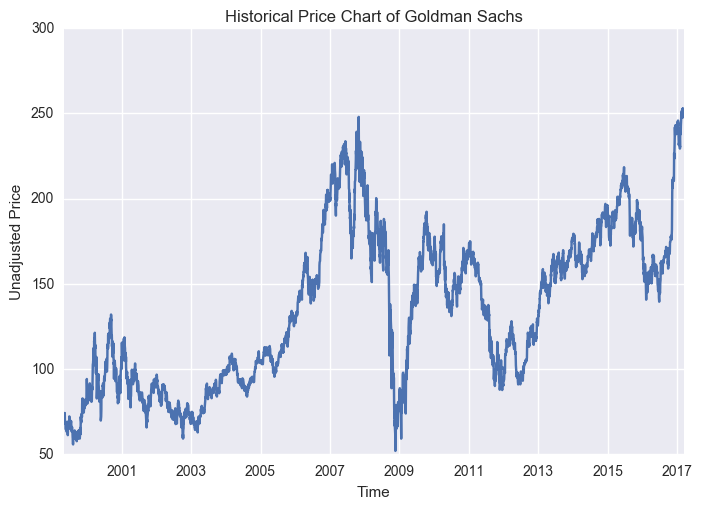

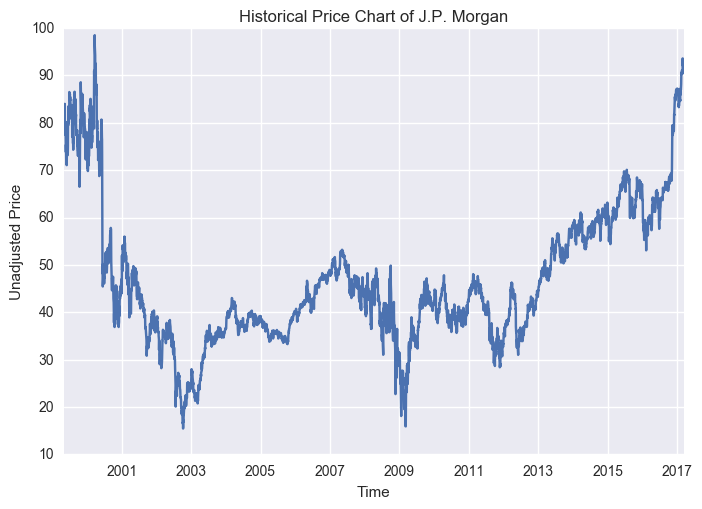

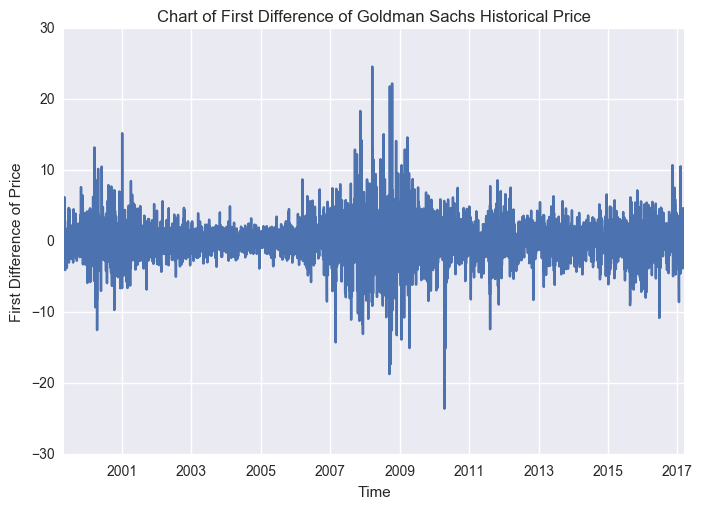

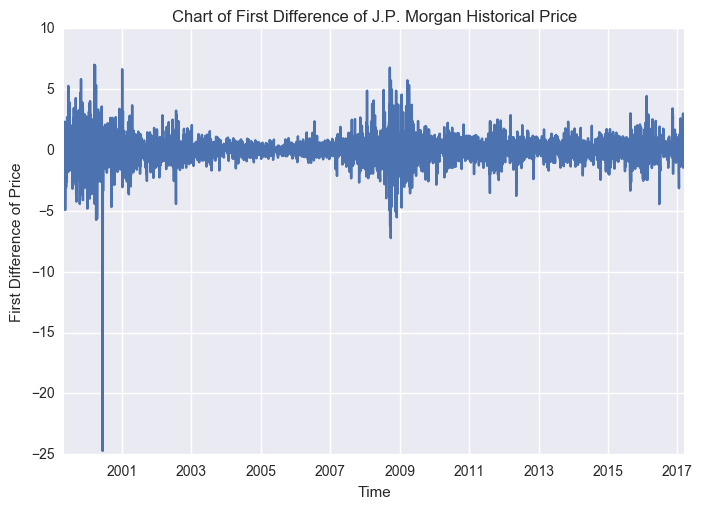

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import quandl

gsdf = quandl.get("WIKI/GS")
jpmdf = quandl.get("WIKI/JPM", start_date="1999-05-04")



plt.plot(gsdf.loc[:, "Close"])
plt.title("Historical Price Chart of Goldman Sachs")
plt.ylabel("Unadjusted Price")
plt.xlabel("Time")
plt.show()

plt.plot(jpmdf.loc[:, "Close"])
plt.title("Historical Price Chart of J.P. Morgan")
plt.ylabel("Unadjusted Price")
plt.xlabel("Time")
plt.show()


time1 = gsdf.index.values[1:]
gs_close = np.array(gsdf.loc[:, "Close"].tolist())
diff_gs = np.diff(gs_close)

plt.plot(time1, diff_gs)
plt.title("Chart of First Difference of Goldman Sachs Historical Price")
plt.ylabel("First Difference of Price")
plt.xlabel("Time")
plt.show()

time2 = jpmdf.index.values[1:]
jpm_close = np.array(jpmdf.loc[:, "Close"].tolist())
diff_jpm = np.diff(jpm_close)

plt.plot(time2, diff_jpm)
plt.title("Chart of First Difference of J.P. Morgan Historical Price")
plt.ylabel("First Difference of Price")
plt.xlabel("Time")
plt.show()



As you can see from the second pair of charts, the first difference of Goldman Sachs is essentially a scaled up version of that of J.P. Morgan. For both, there is similar volatility clustering in the years preceding the dot-com bust, as well as during the recent financial crisis, and finally, in the last year. Even aside from this, the charts look incredibly similar, as do those of the unadjusted price when examined closely. 

While the test still returned "True" when I removed the original start date and used all historical price data available for the companies starting from the day of Goldman's IPO, I cannot guarantee that this will always be the case. This algorithm is susceptible to substantial Type II error, in that it may fail to identify present but temporary cointegration between two series because of the presence of data from a time when the equities were not cointegrated. 

## Conclusion
The next step will be to (a) algorithmize the process of searching for temporary cointegration and (b) add a class that will function as a search algorithm (i.e. given a large quantity of tickers, identify cointegrated pairs). From there, I will have to add in the details of the methods for execution, rebalancing, etc., as well as a risk model. For pairs trading, it would be wise to minimize, or at least manage the amount of acceptable volatility in my pairs, so perhaps an ARCH/GARCH model will be appropriate. This will allow me to supervise the amount of predicted volatility coming into my portfolio, and since I am looking for statistical reversions, I will definitely want to minimize this. The end result will hopefully be a tradeable strategy.